In [1]:
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #解决运行时内核崩溃
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt

torch.set_printoptions(2)

**锚框的宽度和高度分别是 $ws\sqrt{r}$ 和 $hs/ \sqrt{r}$ 我们只考虑组合：**  
$(s_1,r_1),(s_1,r_2),...,(s_1,r_m),(s_2,r_1),(s_3,r_1),...,(s_n,r_1)$  
w和h是输入图片的宽和高，s表示锚框占图片的百分之多少(scale)，r是锚框的高宽比(ratio)  
上面这个组合的意思是，如果给出了n个s和m个r，不会尝试n*m个组合，而是拿第一个s和全部r组合，拿全部s和第一个r组合，总共有n+m-1个组合（每个像素点有这么多个锚框）  
**注意，老师说r是高宽比，但是通常大家认为r是宽高比，因此在.md中我写了“这里的宽高公式反了”，但又没反**

In [2]:
def multibox_prior(data,sizes,ratios):
    """生成以每个像素为中心具有不同高宽度的锚框"""
    # data.shape的最后两个元素为宽和高，第一个元素为通道数
    in_height, in_width = data.shape[-2:]
    # 数据对应的设备、锚框占比个数、锚框高宽比个数
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    # 计算每个像素点对应的锚框数量
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    # 将锚框占比列表转为张量并将其移动到指定设备
    size_tensor = torch.tensor(sizes, device=device)
    # 将宽高比列表转为张量并将其移动到指定设备
    ratio_tensor = torch.tensor(ratios, device=device)
    
    # 定义锚框中心偏移量
    offset_h, offset_w = 0.5, 0.5
    # 计算高度方向上的步长
    steps_h = 1.0 / in_height
    # 计算宽度方向上的步长
    steps_w = 1.0 / in_width
    
    # 生成归一化的高度和宽度方向上的像素点中心坐标
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    # 生成坐标网格
    shift_y, shift_x = torch.meshgrid(center_h, center_w,indexing='ij')
    # 将坐标网格平铺为一维
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    
    # 计算每个锚框的宽度和高度
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                  sizes[0] * torch.sqrt(ratio_tensor[1:]))) \
                    * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                  sizes[0] / torch.sqrt(ratio_tensor[1:])))
    
    # 计算锚框的左上角和右下角坐标（相对于锚框中心的偏移量）
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
    '''
    torch.stack:新增一个维度把输入的张量堆起来
    .repeat(num1,num2):第0维重复num1次，第1维重复num2次
    '''
    # 计算所有锚框的中心坐标，每个像素对应boxes_per_pixel个锚框
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    '''关于torch.stack的dim参数在md文件中写了一些自己的理解'''
    # 通过中心坐标和偏移量计算所有锚框的左上角和右下角坐标
    output = out_grid + anchor_manipulations
    
    # 增加一个维度并返回结果
    return output.unsqueeze(0)

**返回锚框变量`Y`的形状**

img.shape： (561, 728, 3)
561 728
torch.Size([1, 2042040, 4])


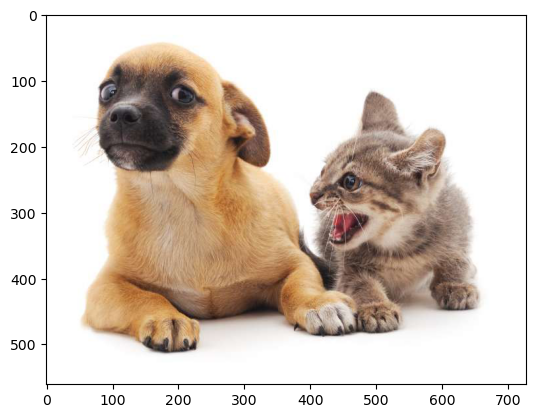

In [3]:
img = plt.imread('img/catdog.jpg')
print("img.shape：",img.shape) # 高561，宽72，3通道
h, w = img.shape[:2]
print(h,w)
X = torch.rand(size=(1,3,h,w)) # 批量大小为1,3通道
Y = multibox_prior(X, sizes=[0.75,0.5,0.25], ratios=[1,2,0.5]) # 占图片sizes尺寸的大小、高宽比ratios尺寸大小的锚框
print(Y.shape) # 1 是批量大小，2042040是一张图片生成的锚框数量，4个元素时每个锚框对应的位置
plt.imshow(img)
plt.show()

**访问以(250,250)为中心的第一个锚框**

In [4]:
boxes = Y.reshape(h,w,5,4)  # 上面的sizes×sizes=3×3，3+3-1=5，故每个像素为中心生成五个锚框    
boxes[250,250,0,:] # 以250×250为中心的第一个锚框的坐标

tensor([0.06, 0.07, 0.63, 0.82])

**访问以一个像素为中心的所有锚框**

In [5]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        # 如果obj为None，使用默认值；如果obj不是列表或元组，将其转换为列表
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    # 处理labels，确保其为列表形式
    labels = _make_list(labels) 
    # 处理colors，确保其为列表形式
    colors = _make_list(colors, ['b','g','r','m','c']) 
    # 遍历所有边界框
    for i, bbox in enumerate(bboxes): 
        # 选择颜色
        color = colors[i % len(colors)] 
        # 使用边界框和颜色生成矩形框
        rect = d2l.bbox_to_rect(bbox.detach().numpy(),color) 
        # 在图像上添加矩形框
        axes.add_patch(rect) 
        # 如果存在标签
        if labels and len(labels) > i: 
            # 根据边界框的颜色选择标签的颜色
            text_color = 'k' if color == 'w' else 'w' 
            # 在边界框上添加标签
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                     ha='center', fontsize=9, color=text_color,
                     bbox=dict(facecolor=color, lw=0))

**访问以(250,250)为中心的所有锚框**

fig.axes： Axes(0.125,0.11;0.775x0.77)
boxes[250,250,:,:]：
 tensor([[ 0.06,  0.07,  0.63,  0.82],
        [ 0.15,  0.20,  0.54,  0.70],
        [ 0.25,  0.32,  0.44,  0.57],
        [-0.06,  0.18,  0.75,  0.71],
        [ 0.14, -0.08,  0.55,  0.98]])
bbox_scale： tensor([728, 561, 728, 561])
boxes[250,250,:,:] * bbox_scale：
 tensor([[ 40.13,  40.12, 460.88, 460.87],
        [110.25, 110.25, 390.75, 390.75],
        [180.38, 180.38, 320.62, 320.62],
        [-47.02, 101.74, 548.02, 399.26],
        [101.74, -47.02, 399.26, 548.02]])


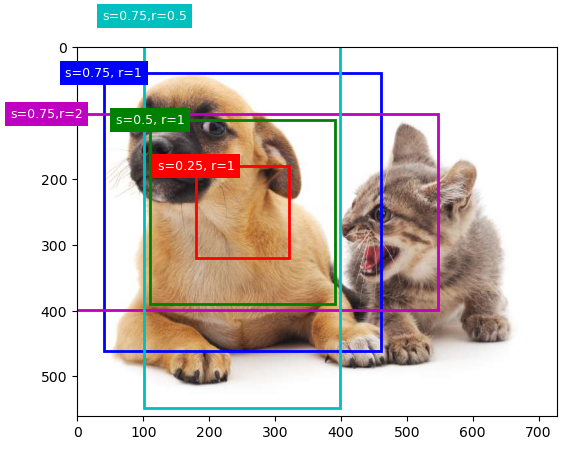

In [6]:
bbox_scale = torch.tensor((w,h,w,h)) 
fig = plt.imshow(img) 
print("fig.axes：",fig.axes)
print("boxes[250,250,:,:]：\n",boxes[250,250,:,:])
print("bbox_scale：", bbox_scale)
print("boxes[250,250,:,:] * bbox_scale：\n",boxes[250,250,:,:] * bbox_scale)
# 画出以250×250像素为中心的不同高宽比的五个锚框
show_bboxes(fig.axes, boxes[250,250,:,:] * bbox_scale, ['s=0.75, r=1','s=0.5, r=1','s=0.25, r=1','s=0.75,r=2','s=0.75,r=0.5']) 
plt.show()

**交并比(IoU)**

In [7]:
def box_iou(boxes1,boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    # 定义一个lambda函数，计算一个锚框或边界框的面积
    box_area = lambda boxes: ((boxes[:,2] - boxes[:,0]) *
                             (boxes[:,3] - boxes[:,1]))
    # 计算boxes1中每个框的面积
    areas1 = box_area(boxes1) 
    # 计算boxes2中每个框的面积
    areas2 = box_area(boxes2) 
    # 计算交集区域的左上角坐标（对于每对框，取其左上角坐标的最大值）
    inter_upperlefts = torch.max(boxes1[:,None,:2],boxes2[:,:2]) 
    # 计算交集区域的右下角坐标（对于每对框，取其右下角坐标的最小值）
    inter_lowerrights = torch.min(boxes1[:,None,2:],boxes2[:,2:])
    # 计算交集区域的宽和高（如果交集不存在，宽和高为0）
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # 两两矩形相交部分的面积
    inter_areas = inters[:,:,0] * inters[:,:,1]
    # 计算并集区域的面积（boxes1的面积 + boxes2的面积 - 交集的面积）
    union_areas = areas1[:,None] + areas2 - inter_areas 
    # 返回交并比（交集的面积除以并集的面积）
    return inter_areas / union_areas

**将真实边界框分配给锚框**

In [8]:
def assign_anchor_to_bbox(ground_truth,anchors,device,iou_threshold=0.5):
    """
    边界框 锚框 设备 iou_threshold：如果一个锚框跟任何一个真实边框的IoU都小于这个值就扔掉不要了，作为背景框
    将最接近的真实边界框分配给锚框
    """
    
    # 获取锚框和真实边界框的数量
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0] 
    
    # 计算所有的锚框和真实边缘框的IOU
    jaccard = box_iou(anchors,ground_truth) 
    
    # 创建一个长度为num_anchors的张量，用-1填充，表示锚框到真实边界框的映射（初始时没有分配）
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device)    
    
    # 对于每个锚框，找到与其IoU最大的真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    
    # 找到IoU大于等于阈值（如0.5）的锚框，将这些锚框分配给对应的真实边界框
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    
    # 初始化用于删除行和列的张量
    col_discard = torch.full((num_anchors,),-1)
    row_discard = torch.full((num_gt_boxes,),-1)
    
    # 通过迭代找到IoU最大的锚框，并将其分配给对应的真实边界框
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard) # 找IOU最大的锚框
        box_idx = (max_idx % num_gt_boxes).long() # 通过取余数操作，得到该元素对应的真实边界框的索引
        anc_idx = (max_idx / num_gt_boxes).long() # 通过整除操作，得到该元素对应的锚框的索引
        
        # 更新锚框到真实边界框的映射
        anchors_bbox_map[anc_idx] = box_idx
        
        # 在jaccard矩阵中删除已分配的锚框所在的行和列，以避免重复分配
        jaccard[:,box_idx] = col_discard # 把最大Iou对应的锚框在 锚框-类别 矩阵中的一列删掉
        jaccard[anc_idx,:] = row_discard # 把最大Iou对应的锚框在 锚框-类别 矩阵中的一行删掉
    
    #函数返回一个张量anchors_bbox_map，它的长度与锚框的数量相同。
    #这个张量用于存储每个锚框分配到的真实边界框的索引。
    #如果某个锚框没有分配到真实边界框，那么在这个张量中对应的位置就会是-1。
    #如果某个锚框分配到了真实边界框，那么在这个张量中对应的位置就会是分配到的真实边界框的索引。  
    #例如，如果我们有5个锚框和3个真实边界框，那么anchors_bbox_map可能会是这样的：[0, -1, 1, 2, -1]。这表示第1个锚框被分配到了第1个真实边界框，第2个锚框没有被分配到真实边界框，第3个锚框被分配到了第2个真实边界框，第4个锚框被分配到了第3个真实边界框，第5个锚框没有被分配到真实边界框。
    return anchors_bbox_map

**标记类和偏移**

In [9]:
def offset_boxes(anchors,assigned_bb,eps=1e-6):
    """对锚框偏移量的转换"""
    # 将锚框从(左上角, 右下角)的形式转换为(中心点, 宽度, 高度)的形式
    c_anc = d2l.box_corner_to_center(anchors) 
    # 将被分配的真实边界框从(左上角, 右下角)的形式转换为(中心点, 宽度, 高度)的形式
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb) 
    # 计算中心点的偏移量，并进行缩放
    offset_xy = 10 * (c_assigned_bb[:,:2] - c_anc[:,:2] / c_anc[:,2:]) 
    # 计算宽度和高度的偏移量，并进行缩放
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:,2:] / c_anc[:,2:]) 
    # 将中心点和宽高的偏移量合并在一起
    offset = torch.cat([offset_xy, offset_wh], axis=1) 
    # 返回计算得到的偏移量
    return offset 

**标记锚框的类和偏移量**

In [10]:
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    # 获取批量大小和锚框
    batch_size, anchors = labels.shape[0], anchors.squeeze(0) 
    # 初始化偏移量、掩码和类别标签列表
    batch_offset, batch_mask, batch_class_labels = [], [], [] 
    # 获取设备和锚框数量
    device, num_anchors = anchors.device, anchors.shape[0] 
    # 对于每个样本
    for i in range(batch_size): 
        # 获取该样本的标签
        label = labels[i,:,:] 
        # 将最接近的真实边界框分配给锚框  
        anchors_bbox_map = assign_anchor_to_bbox(label[:,1:],anchors,device) 
        # 生成锚框掩码，用于标记哪些锚框包含目标   
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1,4) 
        # 初始化类别标签 
        class_labels = torch.zeros(num_anchors, dtype=torch.long,device=device) 
        # 初始化被分配的边界框  
        assigned_bb = torch.zeros((num_anchors,4), dtype=torch.float32,device=device) 
        # 获取包含目标的锚框的索引
        indices_true =torch.nonzero(anchors_bbox_map >= 0) 
        # 获取对应的真实边界框的索引
        bb_idx = anchors_bbox_map[indices_true] 
        # 设置包含目标的锚框的类别标签
        class_labels[indices_true] = label[bb_idx,0].long() + 1 
        # 设置被分配的边界框
        assigned_bb[indices_true] = label[bb_idx, 1:] 
        # 计算锚框的偏移量，并通过掩码进行过滤
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask 
        # 将偏移量添加到列表中
        batch_offset.append(offset.reshape(-1)) 
        # 将掩码添加到列表中
        batch_mask.append(bbox_mask.reshape(-1)) 
        # 将类别标签添加到列表中
        batch_class_labels.append(class_labels) 
    # 将所有偏移量堆叠在一起
    bbox_offset = torch.stack(batch_offset) 
    # 将所有掩码堆叠在一起
    bbox_mask = torch.stack(batch_mask) 
    # 将所有类别标签堆叠在一起
    class_labels = torch.stack(batch_class_labels) 
    # 返回每一个锚框到真实标注框的offset偏移
    # bbox_mask为0表示背景锚框，就不用了，为1表示对应真实的物体
    # class_labels为锚框对应类的编号
    # 返回偏移量、掩码和类别标签
    return (bbox_offset, bbox_mask, class_labels) 

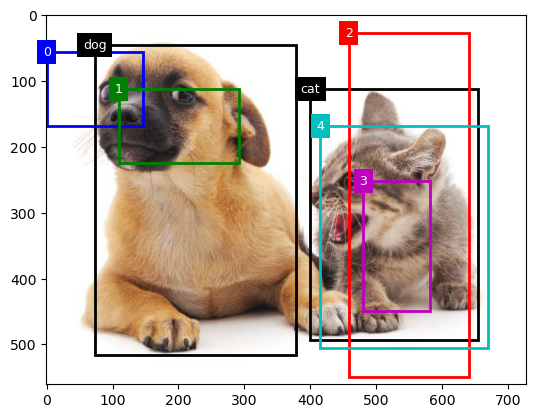

In [11]:
# 在图像中绘制这些地面真相边界框和锚框

# 两个真实边缘框的位置信息
ground_truth = torch.tensor([[0,0.1,0.08,0.52,0.92],
                            [1,0.55,0.2,0.9,0.88]]) # 真实标注框的信息，包括类别标签（0代表狗，1代表猫）和位置信息（归一化的坐标）

# 五个锚框的位置信息
anchors = torch.tensor([[0,0.1,0.2,0.3],[0.15,0.2,0.4,0.4],
                       [0.63,0.05,0.88,0.98],[0.66,0.45,0.8,0.8],
                       [0.57,0.3,0.92,0.9]]) # 锚框的位置信息（归一化的坐标）

fig = plt.imshow(img)
# 在图像上画出真实的边界框，其中'k'代表黑色     
show_bboxes(fig.axes,ground_truth[:,1:] * bbox_scale, ['dog','cat'],'k')       
# 在图像上画出锚框，标注出锚框的索引号
show_bboxes(fig.axes,anchors * bbox_scale, ['0','1','2','3','4']) 
plt.show()

**根据狗和猫的真实边界框，标注这些锚框的分类和偏移量**

In [12]:
# 根据狗和猫的真实边界框，标注这些锚框的分类和偏移量

# anchors.unsqueeze(dim=0)在0号位置加了一个批量维度，该批量维度大小为1
labels = multibox_target(anchors.unsqueeze(dim=0),ground_truth.unsqueeze(dim=0))     
# labels 对应 multibox_target 函数返回的  (bbox_offset, bbox_mask, class_labels)
print(len(labels)) 
# labels[2]有五个锚框 0表示背景、1表示狗、2表示猫 这里3号框被表示为背景是因为被2号框和四号框非极大值抑制了  
print(labels[2]) 
# 锚框是不是对应是真实物体
print(labels[1]) 
# 每一个锚框有四个值，0表示不需要预测，
print(labels[0]) 

3
tensor([[0, 1, 2, 0, 2]])
tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])
tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -7.90e+00, -1.00e+01,
          2.59e+00,  7.18e+00, -2.30e+01, -1.38e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -1.40e+01, -4.60e+00,
          4.17e-06,  6.26e-01]])


**应用逆偏转变换来返回预测的边界框坐标**

In [13]:
def offset_inverse(anchors,offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    # 将锚框从角点表示转换为中心-宽度表示
    anc = d2l.box_corner_to_center(anchors)
    # 利用预测的偏移量和原始锚框，计算预测边界框的中心坐标
    pred_bbox_xy = (offset_preds[:,:2] * anc[:,2:] / 10) + anc[:,:2]
    # 利用预测的偏移量和原始锚框，计算预测边界框的宽度和高度
    pred_bbox_wh = torch.exp(offset_preds[:,2:] / 5) * anc[:, 2:]
    # 将预测边界框的中心坐标和宽高组合在一起，得到预测边界框的中心-宽度表示
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    # 将预测边界框从中心-宽度表示转换为角点表示
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    # 返回预测的边界框
    return predicted_bbox # 将锚框用偏移量进行偏移，得到预测的边界框

**以下`nms`函数按降序对置信度进行排序并返回其索引**

In [14]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    # 按照得分降序排列预测边界框的索引
    B = torch.argsort(scores, dim = -1, descending=True)
    # 创建一个空列表，用于存储保留下来的边界框索引
    keep = []
    # 当B中还有元素时，进行循环
    while B.numel()>0: # 直到把所有框都访问过了，再退出循环
        # 取B中得分最高的边界框索引
        i = B[0] # B中的最大值，已经排好序了
        # 将这个边界框索引添加到保留列表中
        keep.append(i)
        # 如果B中只有一个元素，那么结束循环
        if B.numel() == 1: break
        # 计算剩余的边界框与当前得分最高的边界框的IoU（交并比） 
        iou = box_iou(boxes[i,:].reshape(-1,4),
                     boxes[B[1:],:].reshape(-1,4)).reshape(-1)
        # 找到所有与当前得分最高的边界框的IoU不大于阈值的边界框的索引
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        # 保留那些与当前得分最高的边界框的IoU不大于阈值的边界框
        B = B[inds + 1]
    # 返回保留下来的边界框索引
    return torch.tensor(keep, device=boxes.device)

**将非极大值抑制应用于预测边界框**

In [15]:
def multibox_detection(cls_probs,offset_preds,anchors,nms_threshold=0.5,
                      pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    # 获取设备类型和批次大小
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    # 将锚框数据压缩到二维
    anchors = anchors.squeeze(0)
    # 获取类别数量和锚框数量
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    # 创建一个空列表，用于存储每个批次的预测结果
    out = []
    # 对每个批次进行循环
    for i in range(batch_size): 
        
        # 获取类别概率和预测的偏移量
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1,4)  
        
        # 获取最大类别概率和对应的类别id
        conf, class_id = torch.max(cls_prob[1:],0)
        
        # 根据预测的偏移量和锚框得到预测的边界框
        predicted_bb = offset_inverse(anchors,offset_pred) # 把预测框拿出来
        
        # 对预测的边界框进行非极大值抑制，获取保留下来的边界框索引
        keep = nms(predicted_bb, conf, nms_threshold)
        
        # 获取所有的边界框索引
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        
        # 将保留下来的边界框索引和所有的边界框索引拼接在一起
        combined = torch.cat((keep,all_idx))
        
        # 获取唯一的索引和对应的计数
        uniques, counts = combined.unique(return_counts=True)
        
        # 获取被丢弃的边界框索引
        non_keep = uniques[counts==1]
        
        # 将保留下来的边界框索引和被丢弃的边界框索引按顺序拼接在一起
        all_id_sorted = torch.cat((keep, non_keep))
        
        # 将被丢弃的边界框的类别id设为-1
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        
        # 根据索引获取对应的类别概率和预测的边界框
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted] 
        
        # 找到类别概率低于阈值的边界框索引
        below_min_idx = (conf < pos_threshold)
        
        # 将类别概率低于阈值的边界框的类别id设为-1
        class_id[below_min_idx] = -1
        
        # 将类别概率低于阈值的边界框的类别概率设为1减去原来的值
        conf[below_min_idx] = 1 - conf[below_min_idx]
        
        # 将类别id，类别概率和预测的边界框拼接在一起，作为预测信息
        pred_info = torch.cat((class_id.unsqueeze(1),conf.unsqueeze(1),predicted_bb),dim=1)     
        
        # 将每个批次的预测信息添加到结果列表中
        out.append(pred_info)
        
    # 将结果列表转为张量返回    
    return torch.stack(out)

**将上述算法应用到一个带有四个锚框的具体示例中**

In [16]:
# 四个锚框的坐标
anchors = torch.tensor([[0.1,0.08,0.52,0.92],[0.08,0.2,0.56,0.95],
                       [0.15,0.3,0.62,0.91],[0.55,0.2,0.9,0.88]])

# 偏移预测值，这里假设预测值全为0，即没有预测偏移
offset_preds = torch.tensor([0] * anchors.numel())
print("offset_preds：", offset_preds) # 打印偏移预测值
print("len(offset_preds)：", len(offset_preds)) # 打印偏移预测值的长度

# 类别概率，每一列对应一个锚框，每一行对应一个类别，这里有三个类别：背景、猫、狗
cls_probs = torch.tensor([[0] * 4,  # 背景类别概率
                         [0.9, 0.8, 0.7, 0.1],  # 猫类别概率
                         [0.1, 0.2, 0.3, 0.9]]) # 狗类别概率
print("cls_probs：", cls_probs) # 四个锚框对背景、猫、狗这三个类的预测值，每一列为一个锚框  

offset_preds： tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
len(offset_preds)： 16
cls_probs： tensor([[0.00, 0.00, 0.00, 0.00],
        [0.90, 0.80, 0.70, 0.10],
        [0.10, 0.20, 0.30, 0.90]])


**在图像上绘制这些预测边界框和置信度**

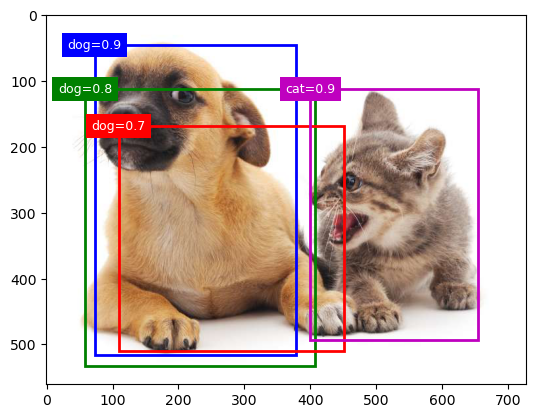

In [17]:
fig = d2l.plt.imshow(img)
# 在图像上显示锚框，其中锚框的尺度需要进行转换以适应图像的尺度
# 每个锚框旁边的文本表示该锚框预测为某个类别的置信度
show_bboxes(fig.axes, anchors * bbox_scale, # 没有做NMS时，把四个锚框画出来
           ['dog=0.9','dog=0.8','dog=0.7','cat=0.9'])
plt.show()

In [18]:
# 使用multibox_detection函数，输入类别预测概率、预测偏移量以及锚框，同时设置非极大值抑制的阈值为0.5
# 注意，这里需要先在输入数据的每个维度上添加一个维度（即批量大小的维度），然后才能传入函数
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                           offset_preds.unsqueeze(dim=0),
                           anchors.unsqueeze(dim=0),nms_threshold=0.5) 
# 打印输出结果，这里的输出结果包含了每个锚框的类别预测、置信度以及经过预测偏移调整后的锚框坐标
# output[0]表示批量中的第一张图片的预测结果
print("output：",output) #output[0]为批量大小中的第一个图片

output： tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])


output[0]： tensor([[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
        [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
        [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
        [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]])
[0.         0.9        0.10000001 0.07999998 0.52       0.92      ]
int(i[0])： 0
str(i[1])： 0.9
label： dog=0.9
[1.         0.9        0.5500001  0.20000002 0.9        0.88      ]
int(i[0])： 1
str(i[1])： 0.9
label： cat=0.9
[-1.          0.8         0.07999998  0.19999999  0.56        0.95      ]
[-1.          0.7         0.14999999  0.3         0.62        0.91      ]


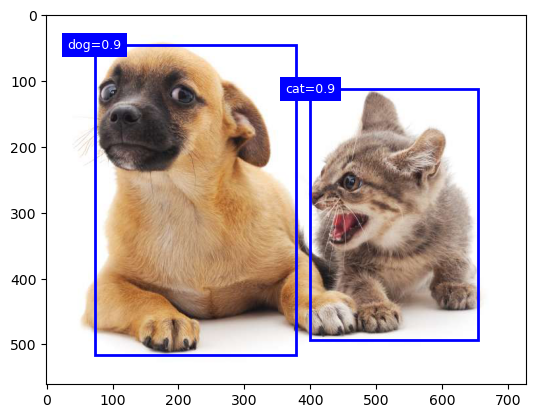

In [19]:
# 输出由非极大值抑制保存的最终预测边界框

# 在图像上绘制通过非极大值抑制筛选后的预测边界框
fig = plt.imshow(img) 

# 输出经过非极大值抑制后的预测结果
print("output[0]：", output[0])

# 遍历预测结果
for i in output[0].detach().numpy(): 
    
    # 输出当前预测结果的详细信息
    print(i)
    
    # 判断如果预测结果的类别为-1，说明这个预测结果表示的是背景或在非极大值抑制中被移除了，所以我们直接跳过这个结果
    if i[0] == -1: # 值-1表示背景或在非极大值抑制中被移除了
        continue
        
    # 打印预测的类别和置信度
    print("int(i[0])：", int(i[0]))  # i[0]=0表示狗，i[0]=1表示猫，即i的第一个元素表示框对应的类别   
    print("str(i[1])：", str(i[1]))  # i的第二元素表示该类别的置信度
    
    # 根据预测的类别和置信度生成标签
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1]) # 取('dog=', 'cat=')元组的第int(i[0]位置与str(i[1])进行拼接             
    print("label：",label)
    
    # 在图像上绘制预测的边界框和标签
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)
plt.show()